In [1]:
# pymc3 install if not exist.
#!pip install pymc3

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import pymc3 as pm
import theano.tensor as tt

# グラフ描画系
import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc

from matplotlib import animation as ani
from IPython.display import Image

plt.rcParams["patch.force_edgecolor"] = True
#rc('text', usetex=True)
from IPython.display import display # Allows the use of display() for DataFrames
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

%matplotlib inline
%config InlineBackend.figure_format='retina'

/Users/kenichi.matsui/anaconda3/envs/kaggle_3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import japanize_matplotlib

In [4]:
result_df = pd.read_csv("../data/bleague_game_result_2018.csv", index_col=0, parse_dates=["game_date"])

In [5]:
result_df.head()

,away_score,away_team,home_score,home_team,month,date,year,game_date,home_win
0,81,川崎,72,千葉,10,4,2018,2018-10-04,-1
1,84,琉球,67,秋田,10,6,2018,2018-10-06,-1
2,64,京都,77,三遠,10,6,2018,2018-10-06,1
3,78,新潟,73,滋賀,10,6,2018,2018-10-06,-1
4,74,大阪,68,北海道,10,6,2018,2018-10-06,-1


In [6]:
lbl = LabelEncoder()
result_df.home_team = lbl.fit_transform(result_df.home_team)
result_df.away_team = lbl.transform(result_df.away_team)

In [7]:
result_df.head()

,away_score,away_team,home_score,home_team,month,date,year,game_date,home_win
0,81,10,72,6,10,4,2018,2018-10-04,-1
1,84,15,67,17,10,6,2018,2018-10-06,-1
2,64,4,77,3,10,6,2018,2018-10-06,1
3,78,11,73,14,10,6,2018,2018-10-06,-1
4,74,8,68,5,10,6,2018,2018-10-06,-1


In [8]:
result_df.tail()

,away_score,away_team,home_score,home_team,month,date,year,game_date,home_win
536,73,13,89,11,4,21,2019,2019-04-21,1
537,51,4,52,8,4,21,2019,2019-04-21,1
538,84,7,83,16,4,21,2019,2019-04-21,-1
539,74,5,81,0,4,21,2019,2019-04-21,1
540,79,14,85,15,4,21,2019,2019-04-21,1


In [9]:
team_name_list = lbl.inverse_transform(range(18))

In [10]:
n_team = len(lbl.classes_)
print(f"{n_team} teams in B-league")

18 teams in B-league


In [11]:
with pm.Model() as model:
    # model definition
    mu_att = pm.Normal("mu_att", 0, .001)
    mu_dfn = pm.Normal("mu_dfn", 0, .001)
    std_att = pm.Gamma("std_att", .1, .1)
    std_dfn = pm.Gamma("std_dfn", .1, .1)
    
    att = pm.Normal("attack", mu=mu_att, sigma=std_att, shape=n_team)
    dfn = pm.Normal("defense", mu=mu_dfn, sigma=std_dfn, shape=n_team)
    
    intercept = pm.Flat("intercept")
    home = pm.Flat('home')
    
    home_theta = tt.exp(intercept + home + att[result_df.home_team.values] + dfn[result_df.away_team.values])
    away_theta = tt.exp(intercept + att[result_df.away_team.values] + dfn[result_df.away_team.values])
    
    home_points = pm.Poisson("home_points", mu=home_theta, observed=result_df.home_score.values)
    away_points = pm.Poisson("away_points", mu=away_theta, observed=result_df.away_score.values)
    
    # sampling
    trace = pm.sample(1000, tune=2000, target_accept=0.95, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, intercept, defense, attack, std_dfn, std_att, mu_dfn, mu_att]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:30<00:00, 396.94draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [12]:
var_names = [name for name in  trace.varnames if name.find("_log__")==-1]
var_names

['mu_att',
 'mu_dfn',
 'attack',
 'defense',
 'intercept',
 'home',
 'std_att',
 'std_dfn']

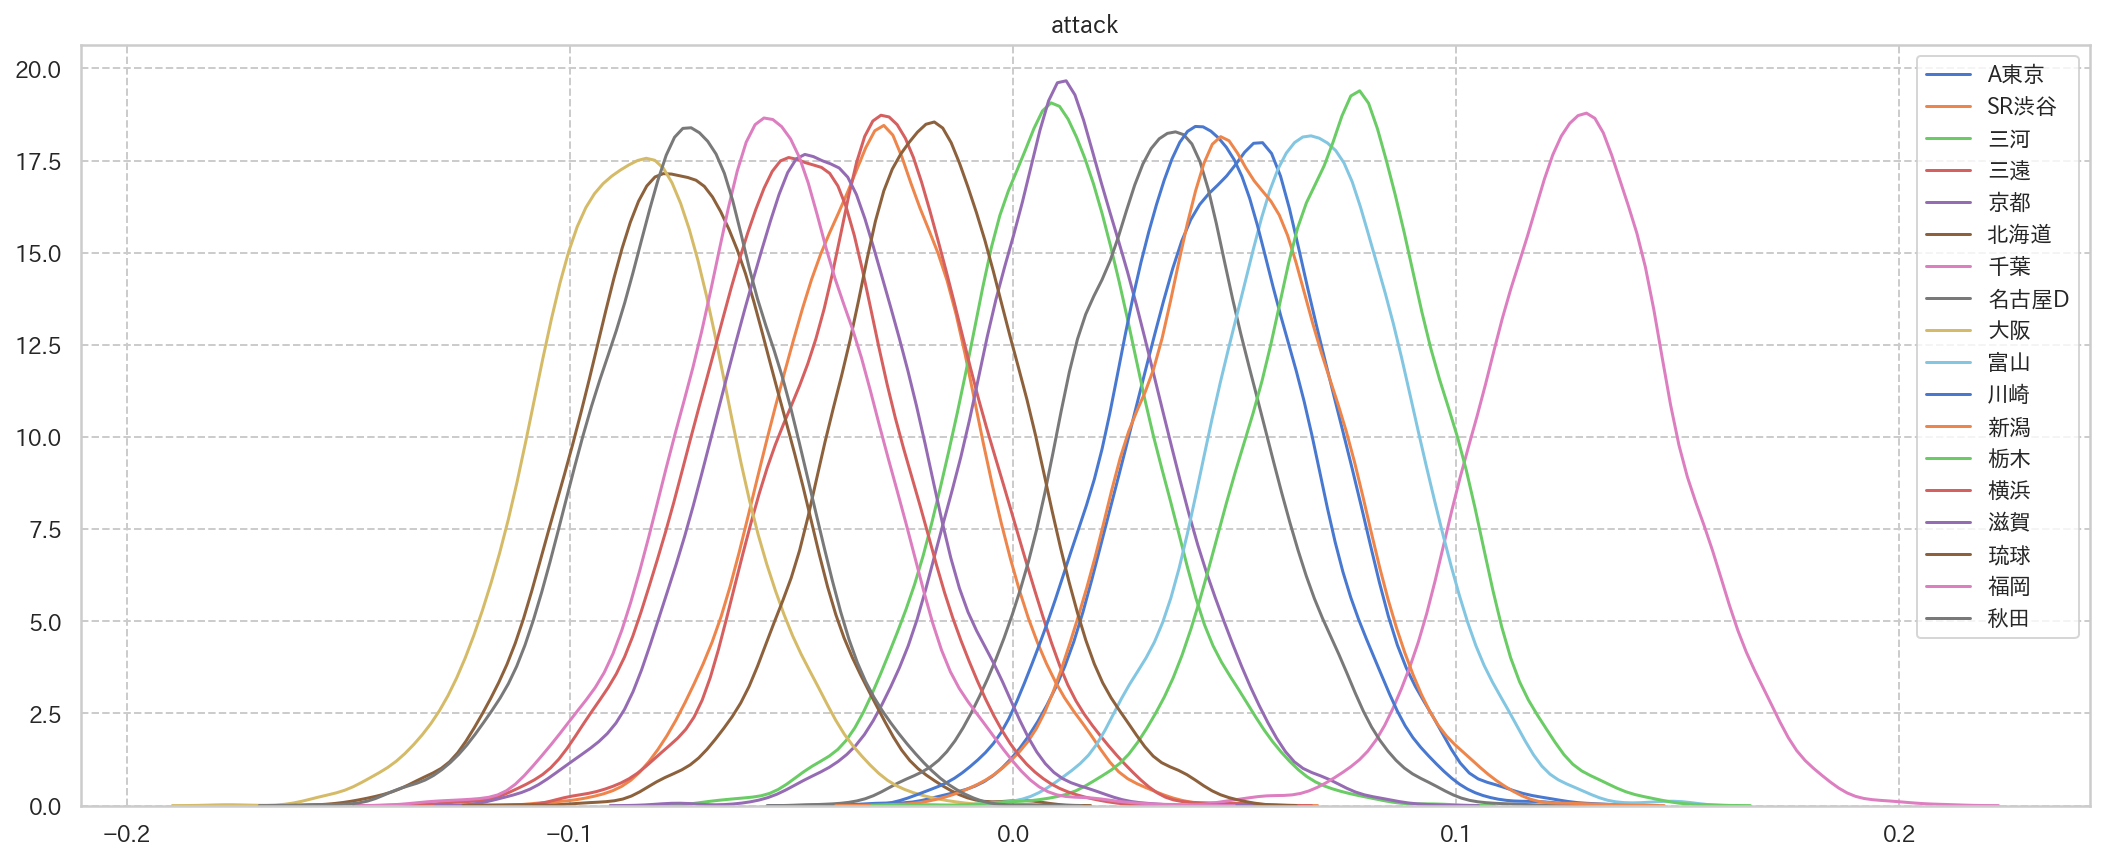

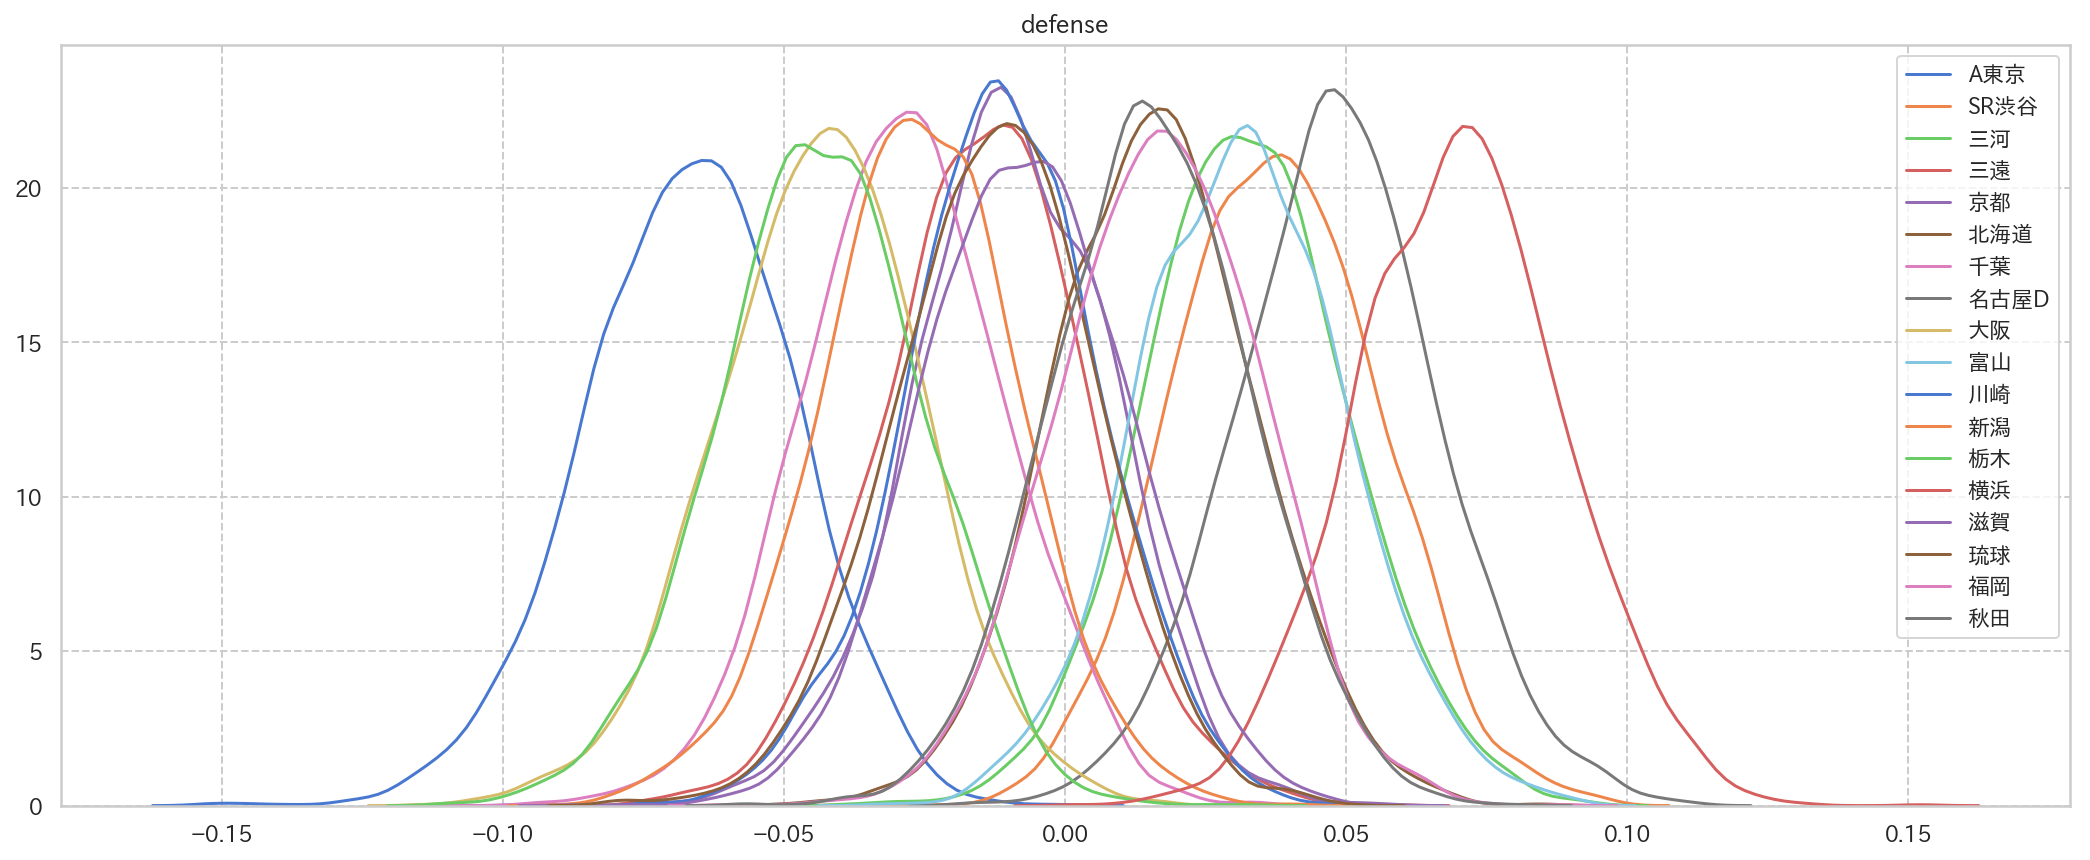

In [13]:
for col in ["attack", "defense"]:
    plt.figure(figsize=(18, 7))
    for i, name in zip(range(trace[col].shape[1]), team_name_list):
        sample = trace[col][:, i]
        sns.kdeplot(sample, label=name)
    plt.title(f"{col}")

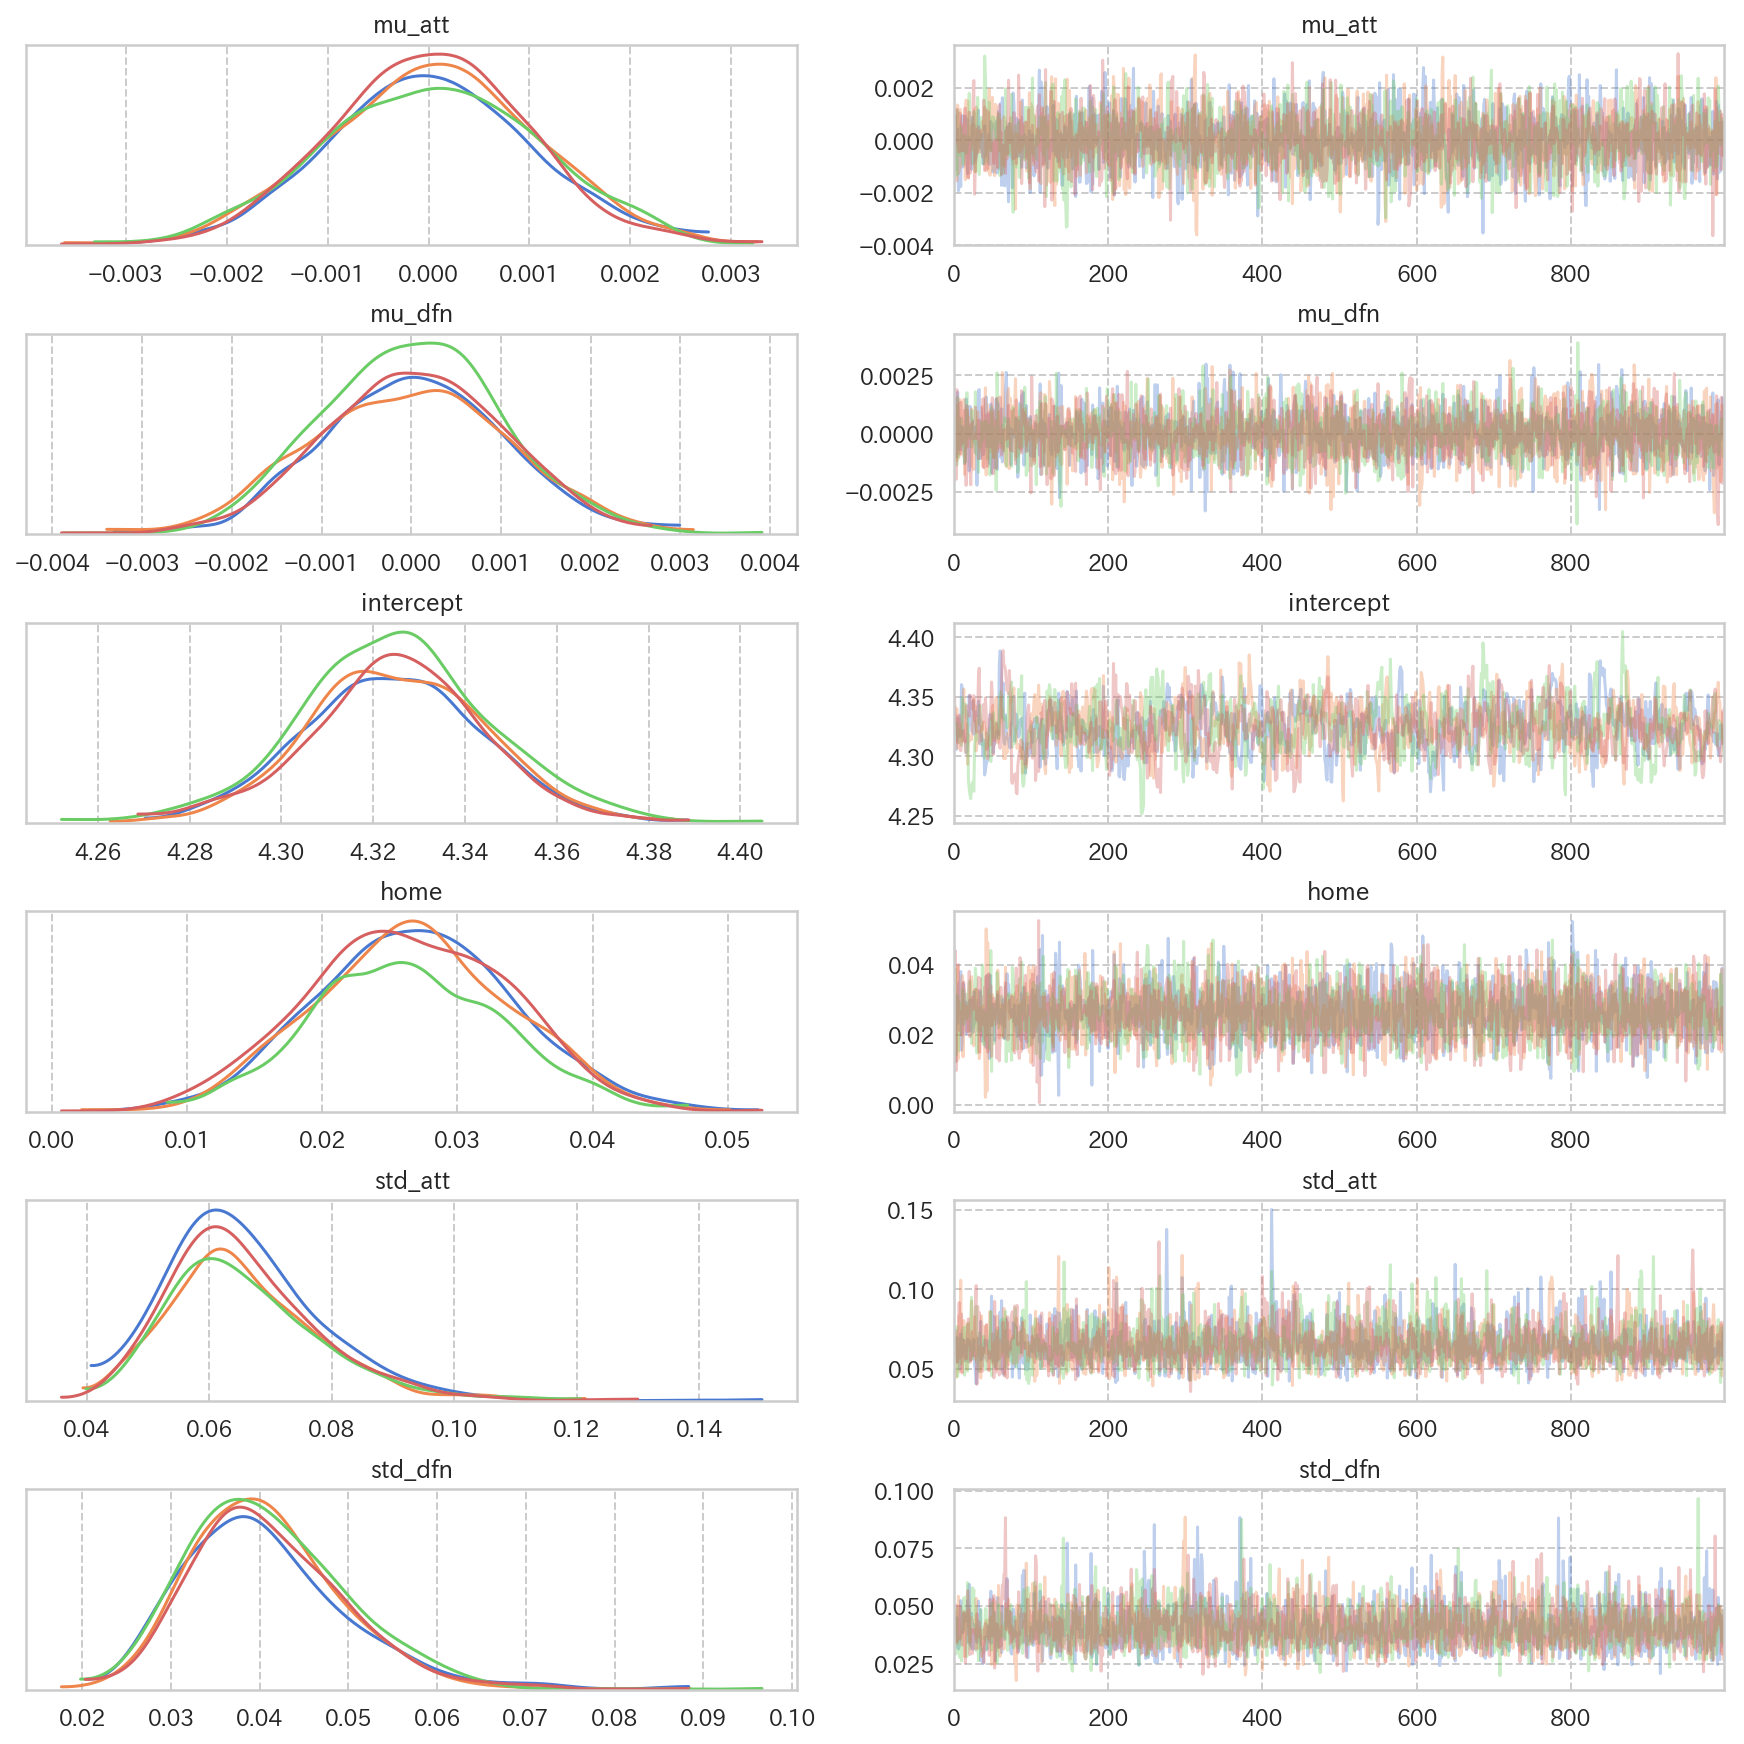

In [14]:
pm.traceplot(trace, var_names=['mu_att',
                               'mu_dfn',
                               'intercept',
                               'home',
                               'std_att',
                               'std_dfn']);

In [15]:
summary = pm.summary(trace, varnames=var_names)

In [16]:
atk_dfn_map = {f"{type_name}__{i}": f"{type_name}__{name}" for i, name in zip(range(18), team_name_list) 
               for type_name in ["attack", "defense"]}
summary.rename(index=atk_dfn_map, inplace=True)

In [17]:
summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu_att,0.000014,0.001013,0.000013,-0.002009,0.001969,4777.568743,0.999591
mu_dfn,0.000004,0.001015,0.000015,-0.001831,0.002038,5031.129227,0.999981
attack__A東京,0.050365,0.021939,0.000650,0.008294,0.093844,1140.038223,0.999619
attack__SR渋谷,-0.030848,0.021869,0.000629,-0.075083,0.010891,1177.728060,0.999573
attack__三河,0.009239,0.022048,0.000651,-0.033524,0.054451,1148.068084,0.999616
attack__三遠,-0.028842,0.022192,0.000638,-0.068439,0.018982,1157.831957,0.999992
attack__京都,0.012363,0.021888,0.000632,-0.030984,0.055723,1209.437919,0.999985
attack__北海道,-0.075110,0.022378,0.000643,-0.117060,-0.029647,1227.565120,0.999944
attack__千葉,0.127610,0.021660,0.000652,0.087425,0.171365,1077.729787,0.999885
attack__名古屋D,0.034365,0.021992,0.000627,-0.008883,0.077081,1132.854726,1.001246


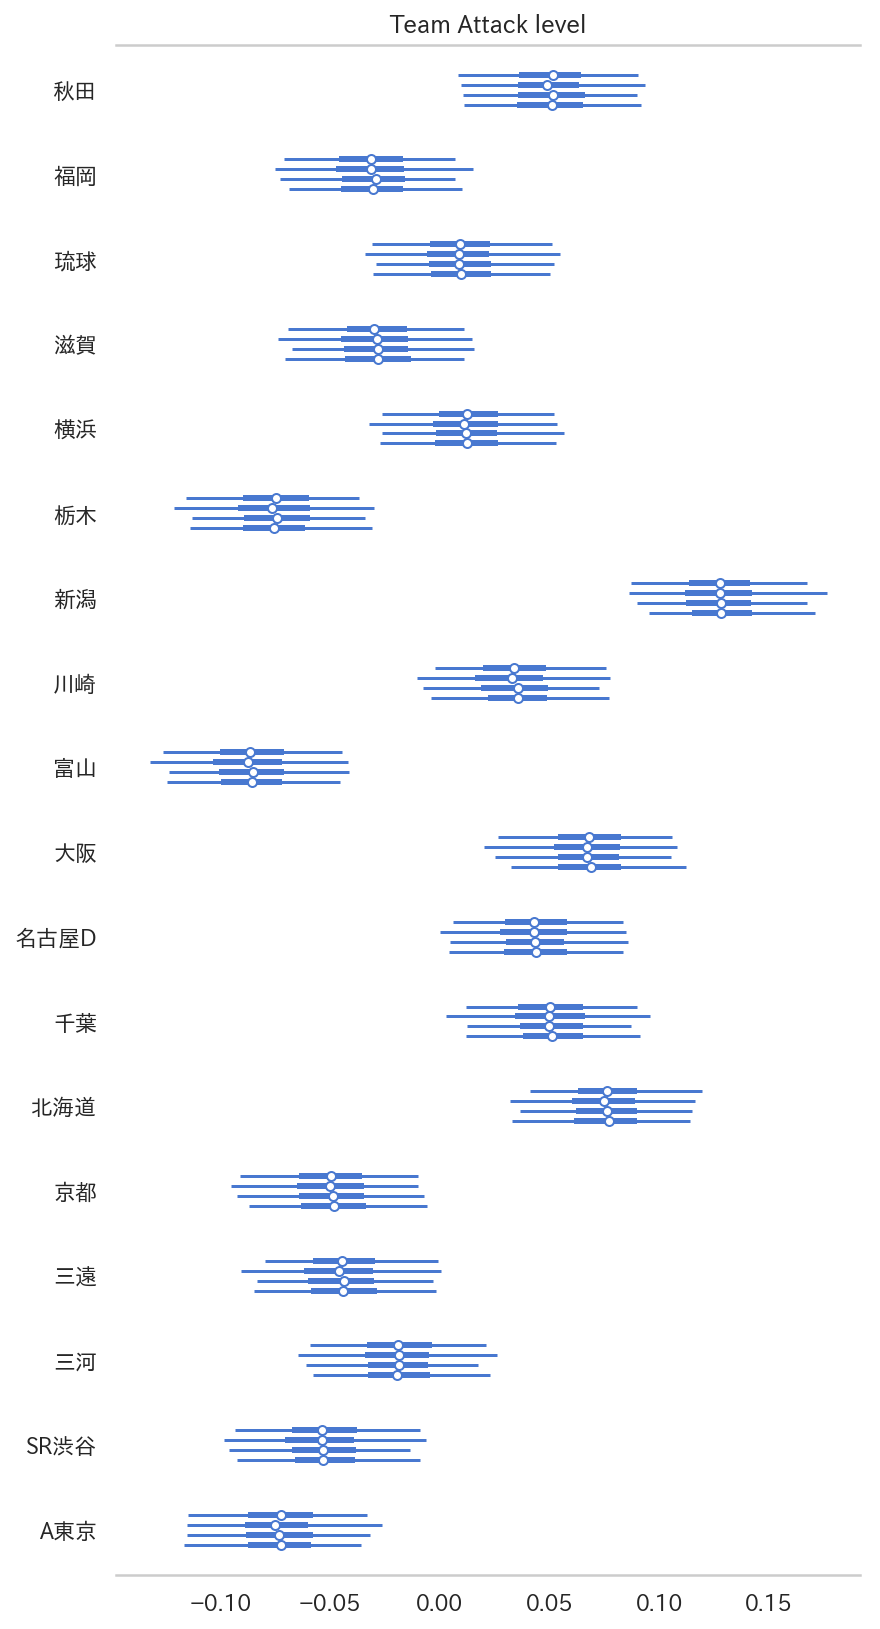

In [18]:
_, ax = pm.forestplot(trace, var_names=['attack'])
ax[0].set_yticklabels(team_name_list)
ax[0].set_title('Team Attack level');

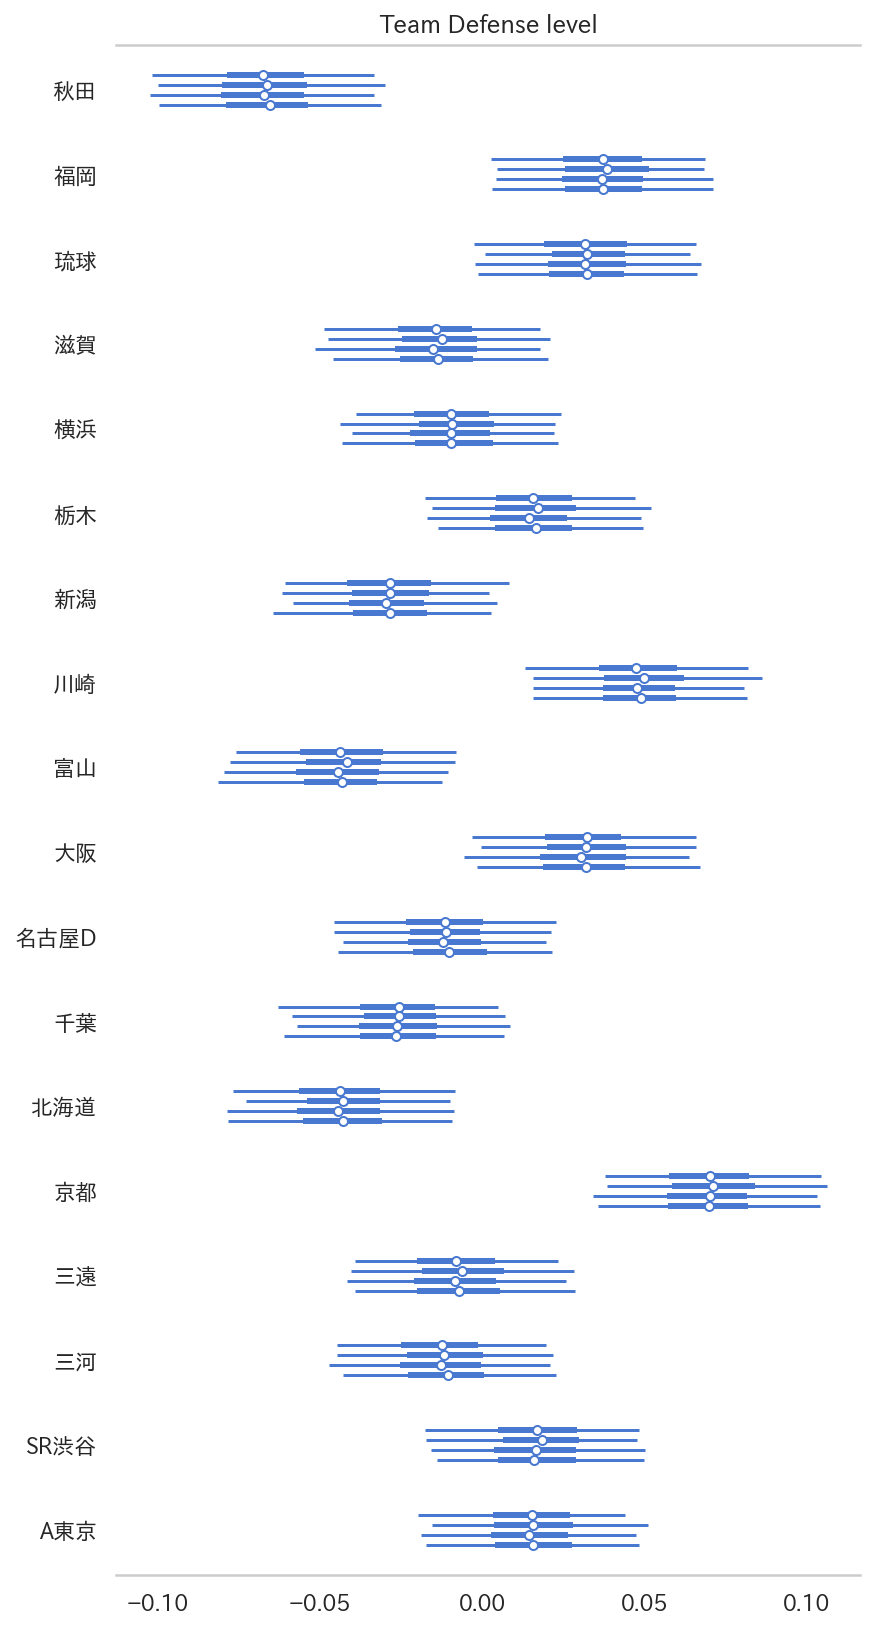

In [19]:
_, ax = pm.forestplot(trace, var_names=['defense'])
ax[0].set_yticklabels(team_name_list)
ax[0].set_title('Team Defense level');

In [20]:
ppc = pm.sample_posterior_predictive(trace, samples=500, model=model, )

100%|██████████| 500/500 [00:00<00:00, 852.38it/s]


In [38]:
def get_home_win_prob(ppc, i):
    draw_match = ppc['home_points'][:,i] == ppc['away_points'][:,i]
    match_result = (ppc['home_points'][:,i] >= ppc['away_points'][:,i])[~draw_match].astype(int)
    return match_result.mean()

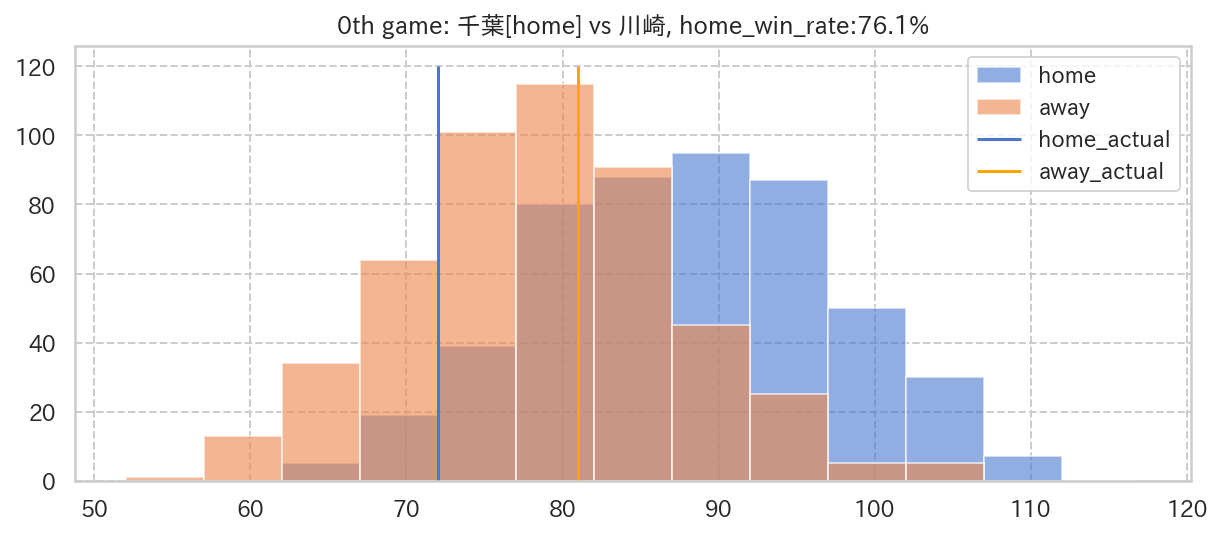

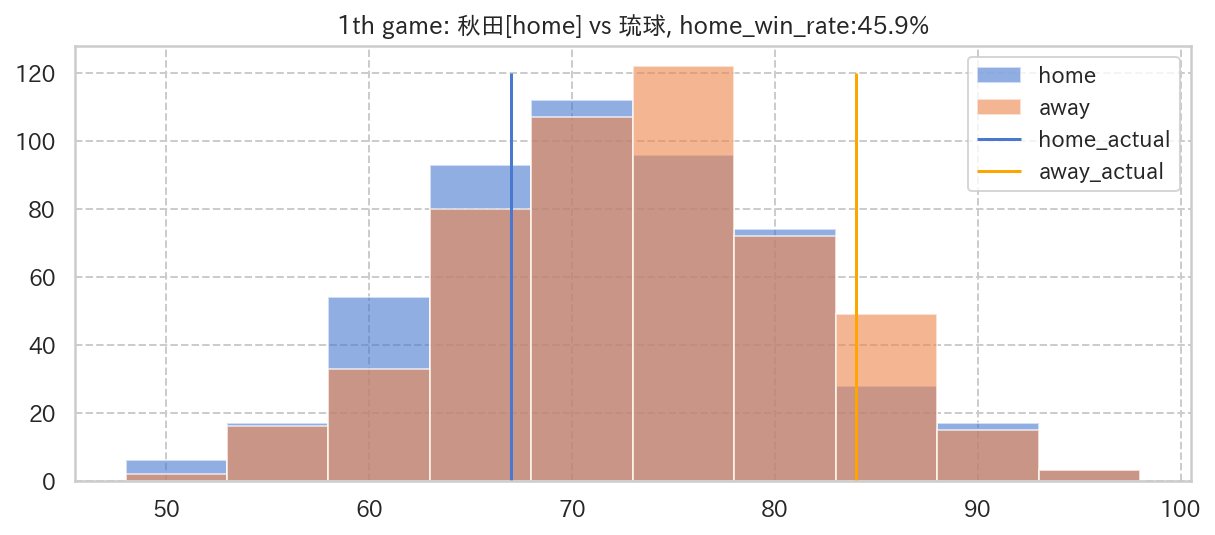

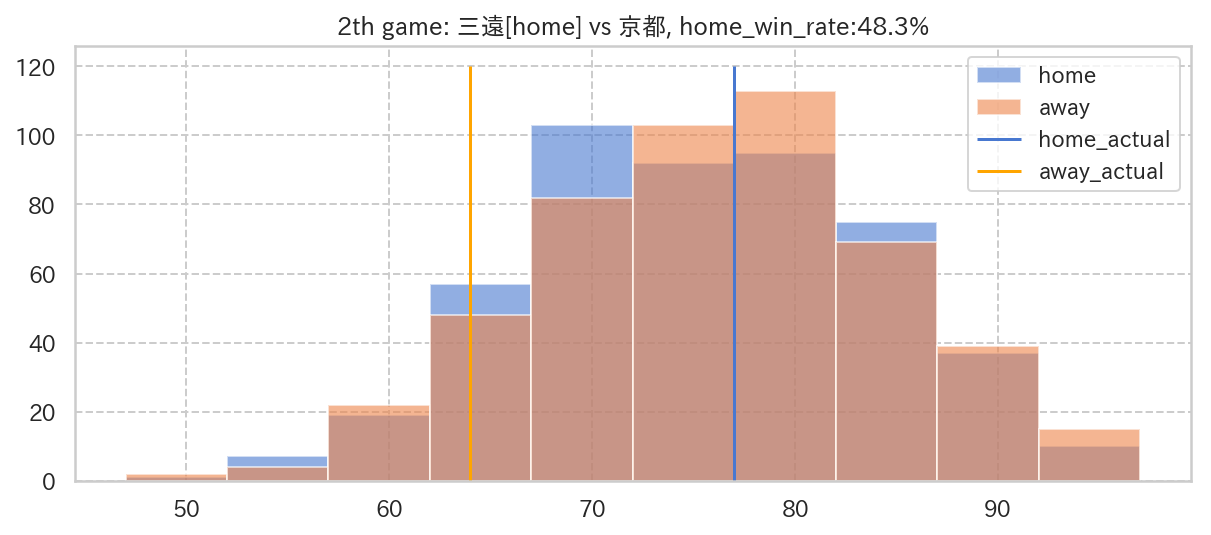

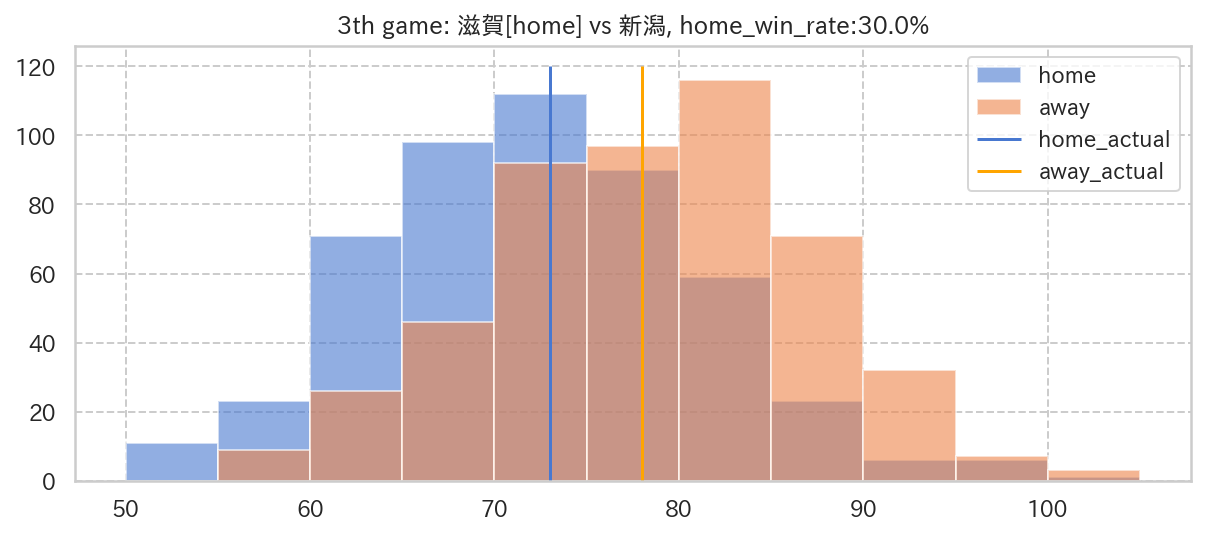

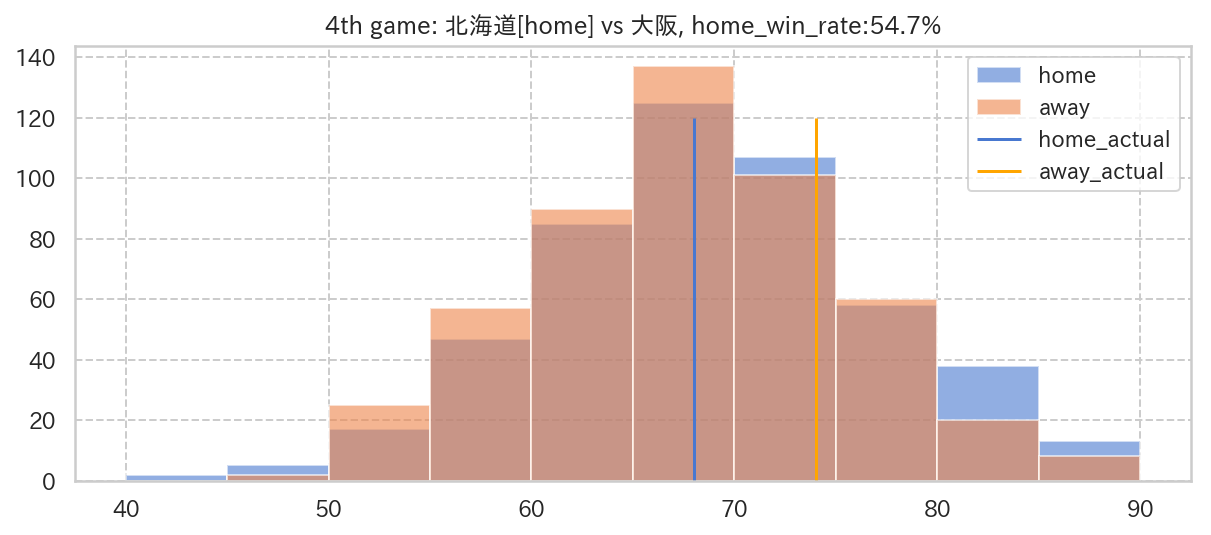

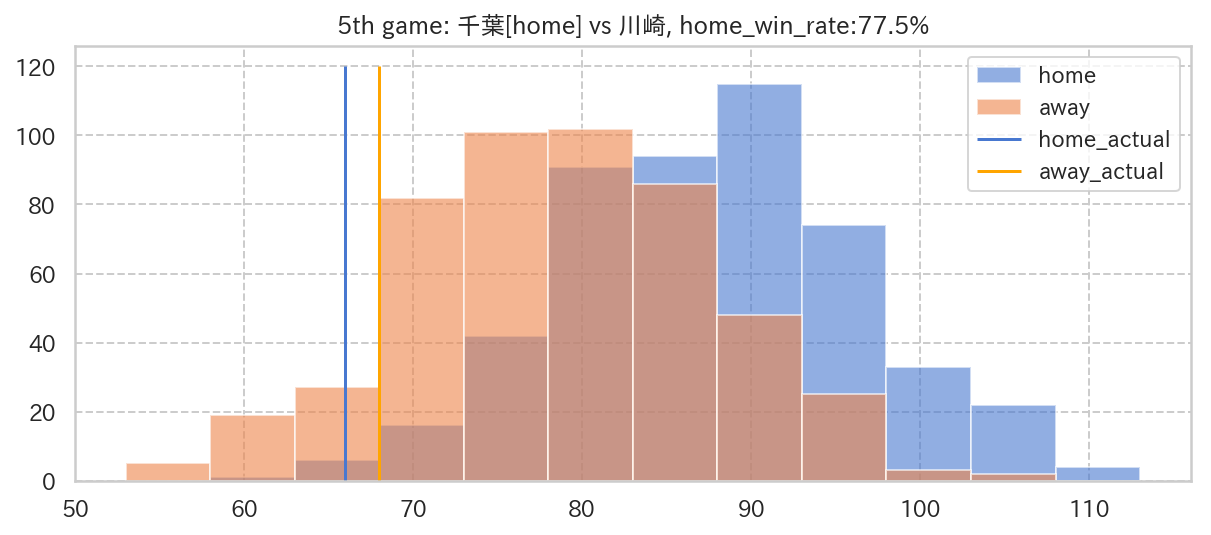

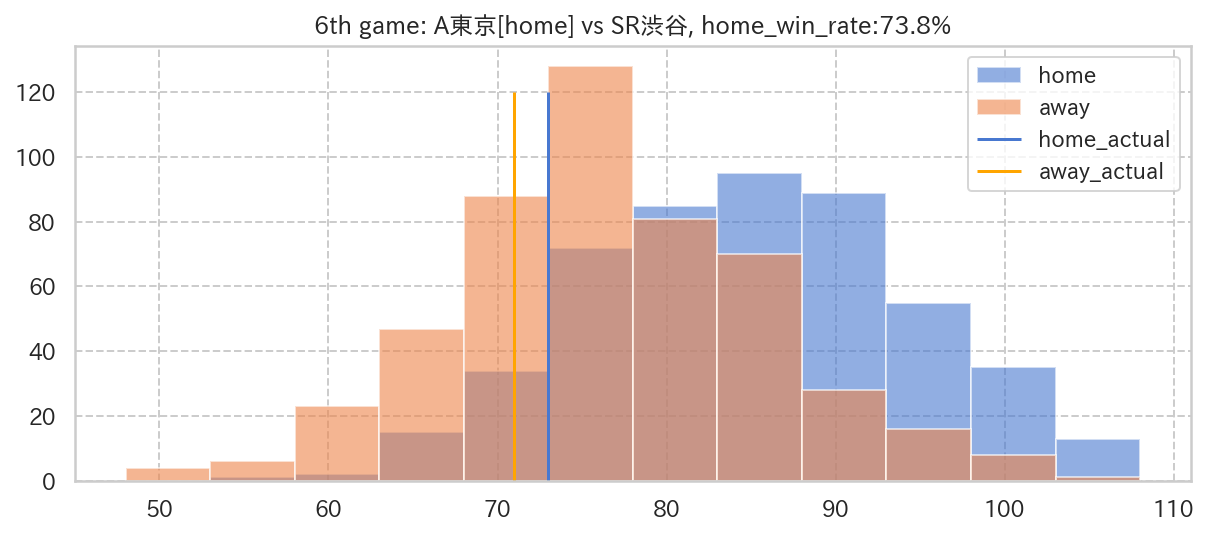

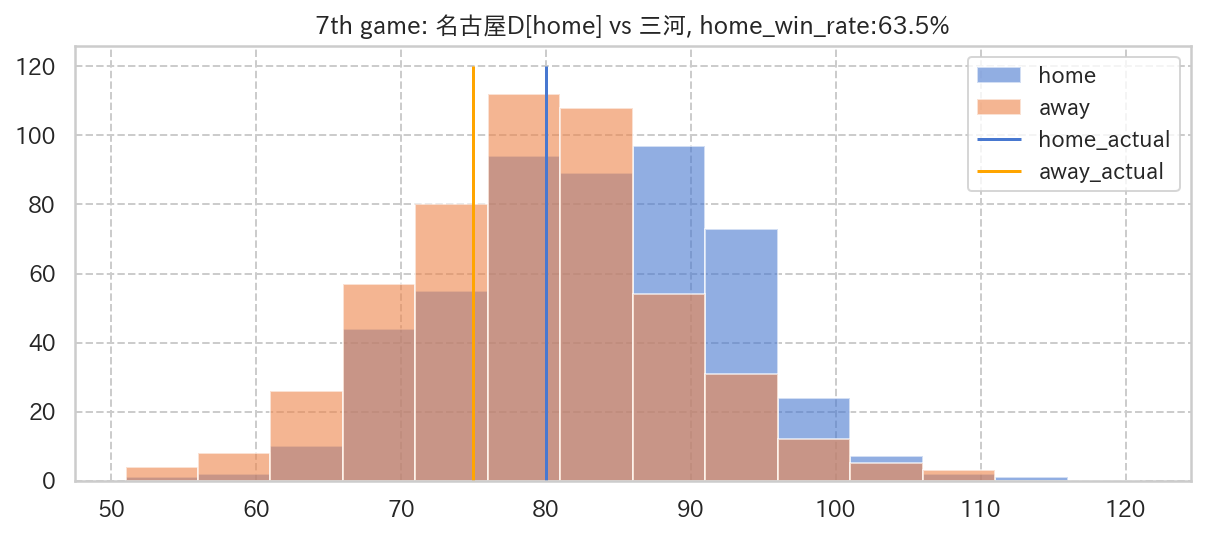

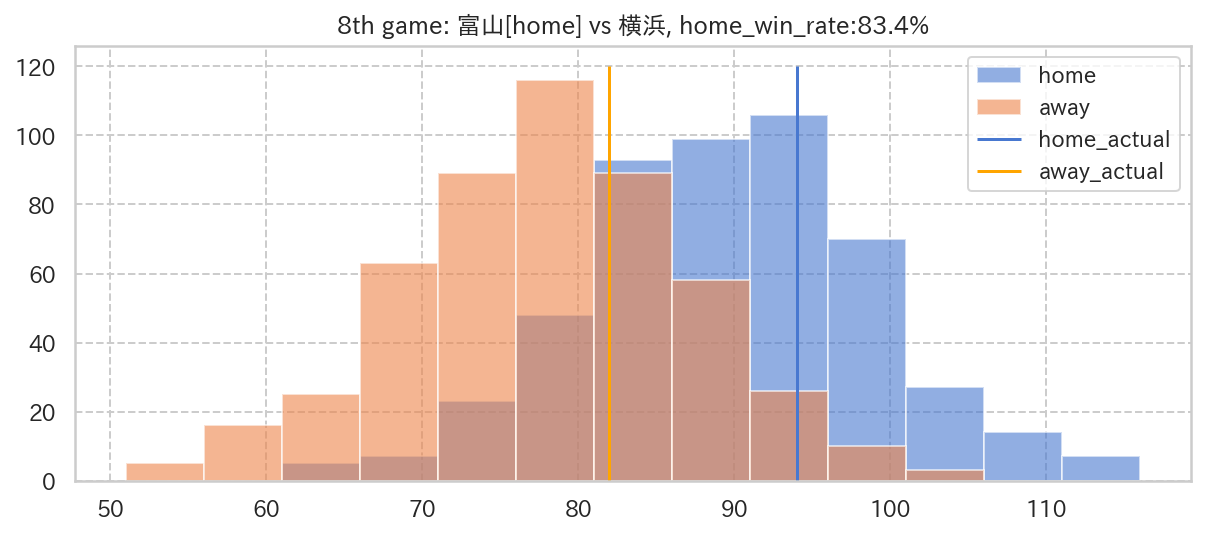

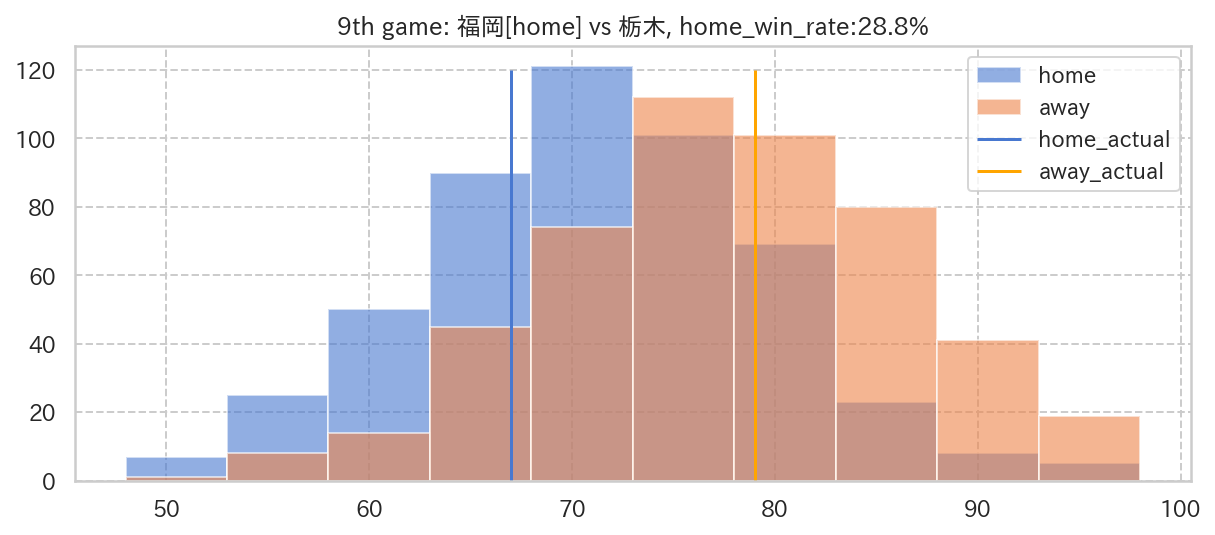

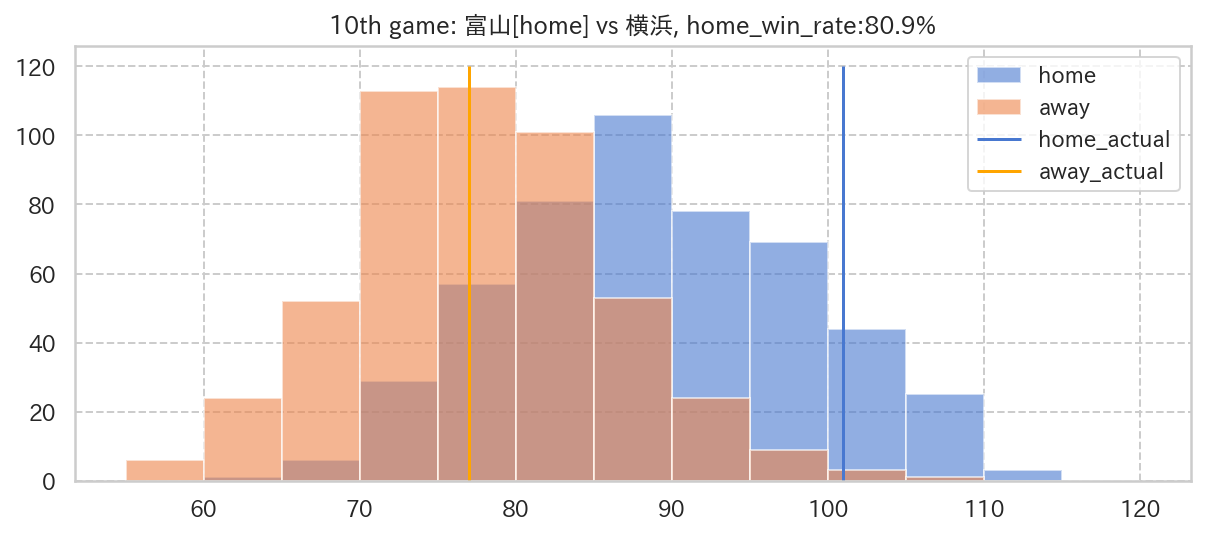

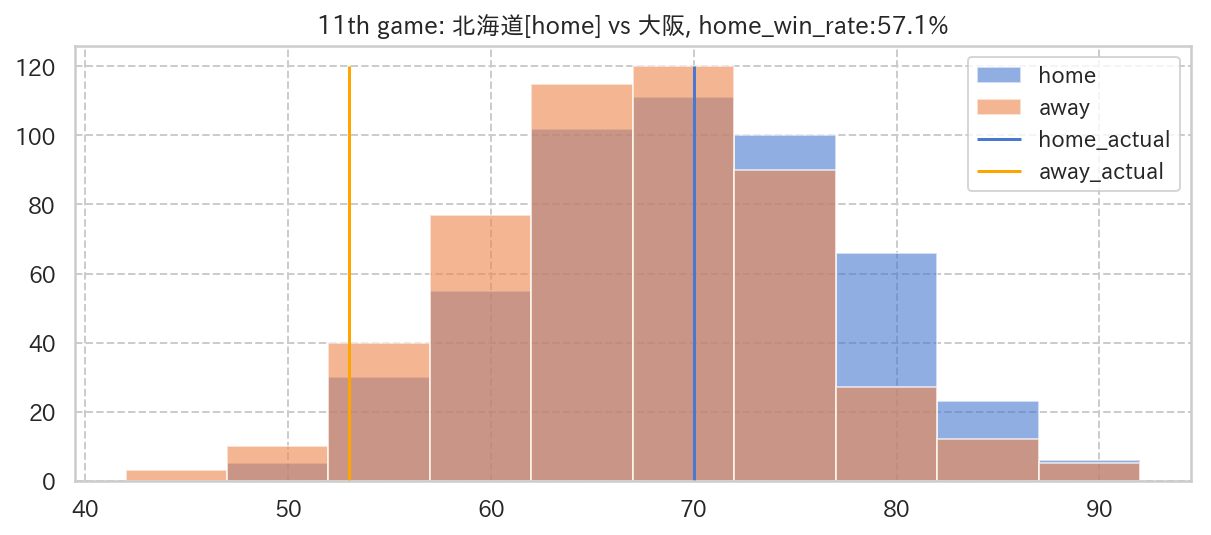

In [39]:
for i in range(result_df.shape[0]):
    df_s = result_df.loc[i]
    max_score = np.max(np.hstack([ppc['home_points'][:,i], ppc['away_points'][:,i]]))
    min_score = np.min(np.hstack([ppc['home_points'][:,i], ppc['away_points'][:,i]]))
    bins = np.arange(min_score, max_score, 5)
    home_win_prob = get_home_win_prob(ppc, i)
    home_team = team_name_list[df_s.home_team]
    away_team = team_name_list[df_s.away_team]
    
    plt.figure(figsize=(10, 4))
    plt.hist(ppc['home_points'][:,i], bins=bins, alpha=0.6, label="home")
    plt.hist(ppc['away_points'][:,i], bins=bins, alpha=0.6, label="away")
    plt.vlines(df_s.home_score, 0, 120, "b", label="home_actual")
    plt.vlines(df_s.away_score, 0, 120, "orange", label="away_actual")
    plt.legend(loc="best")
    plt.title(f"{i}th game: {home_team}[home] vs {away_team}, home_win_rate:{home_win_prob*100:.1f}%")
    plt.show()
    
    if i > 10:
        break